# Predicting the Outcome of NHL Games

Sports over time have been largely dominated by the use of numbers and statistics. Moneyball, the 2011 movie demonstrating a statistical approach in developing a competitive team using baseball statistics, shows one approach of how statistics, and machine learning to an extent, can predict and optimize the outcome of sports (in this case it was choosing players for a team).

Today I will be attempting to see if I can predict the outcome of NHL matches using machine learning tools, particularly the Random Forest Classifier.

<img src="files/SportsReference.png">

The datasets I will be using are from www.hockey-reference.com, part of the www.sports-reference.com sites. Sports-Reference has other excellent data including:
- College Football (and NFL)
- College Basketball (and NBA)
- Olympic Sports
- NHL

The huge amount of data available on these sites are an excellent source to practice machine learning as much of the data is cleaned and well organized.

Here are the direct links if you wish to view the two datasets I use to build my model:

- Games 2014 data: http://www.hockey-reference.com/leagues/NHL_2014_games.html
- Standings 2013 data: http://www.hockey-reference.com/leagues/NHL_2013_standings.html

## Getting Started: Preliminary Setup

Let's begin by exporting the data as well as fixing any issues such as renaming columns.

In [2]:
import os
import numpy as np
import pandas as pd

os.chdir('C:/Users/Kevin/My Project/Hockey')
games_filename = ('leagues_NHL_2014_games_games.csv')
playoff_filename = ('leagues_NHL_2014_games_games_playoffs.csv')

In [3]:
# Let's take a look at the datafile containing all the matches:
results = pd.read_csv(games_filename)
results_playoff = pd.read_csv(playoff_filename)

results.head()

,Date,Visitor,G,Home,G.1,Unnamed: 5,Unnamed: 6,Att.,LOG,Notes,Notes.1
0,2013-10-01,Washington Capitals,4.0,Chicago Blackhawks,6.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-10-01,Winnipeg Jets,5.0,Edmonton Oilers,4.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-10-01,Toronto Maple Leafs,4.0,Montreal Canadiens,3.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-10-02,Anaheim Ducks,1.0,Colorado Avalanche,6.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-10-02,Buffalo Sabres,1.0,Detroit Red Wings,2.0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Did Pandas interpret the "Date" column as actual dates?
results.dtypes.head(1)

Date    object
dtype: object

Pandas did not interpret the 'Date' column as actual dates, we will need to add an extra parameter in our "read_csv" function to fix this issue.

The dataset for the 2014 games are split up into two different datasets:
1. Regular Season
2. Playoff Season

I will combine both datasets into a single dataframe.

In [5]:
# Import both datasets
results1 = pd.read_csv(games_filename, parse_dates=["Date"])
results2 = pd.read_csv(playoff_filename, parse_dates=["Date"])

In [6]:
# We will be using "results" as our main dataframe when building our model
results = results1.append(results2, ignore_index=True)

In [7]:
# Let us clean and fix some of the issues in the dataframe above
# Fix the names of the columns
results.columns = ["Date", "Visitor Team", "Visitor Goals", "Home Team", "Home Goals", \
                   "Overtime", "Blank", "Att", "LOG", "Notes1", "Notes2"]

# Delete the columns we do not need in our analysis
results = results.drop(results.columns[[5,6,7,8,9,10]], axis=1)

In [8]:
# Lets view our cleaned dataframe
results.ix[:5]

,Date,Visitor Team,Visitor Goals,Home Team,Home Goals
0,2013-10-01,Washington Capitals,4.0,Chicago Blackhawks,6.0
1,2013-10-01,Winnipeg Jets,5.0,Edmonton Oilers,4.0
2,2013-10-01,Toronto Maple Leafs,4.0,Montreal Canadiens,3.0
3,2013-10-02,Anaheim Ducks,1.0,Colorado Avalanche,6.0
4,2013-10-02,Buffalo Sabres,1.0,Detroit Red Wings,2.0
5,2013-10-02,Toronto Maple Leafs,3.0,Philadelphia Flyers,1.0


## Team Name Change

In preparing our model, we will be working with team names from the 2013 and 2014 seasons.

- There is a change in a team name moving forward in the 2015 season and we will need to address this issue early on
- The Phoenix Coyotes changed their name to the Arizona Coyotes

<img src="coyotes.png">
Let's change their team name in our dataframe:

In [9]:
# The team names appear in both the 'Visitor Team' and 'Home Team' columns so we need to make changes in both columns
results["Visitor Team"] = results["Visitor Team"].replace("Phoenix Coyotes", "Arizona Coyotes")
results["Home Team"] = results["Home Team"].replace("Phoenix Coyotes", "Arizona Coyotes")

## Create the class to predict

We are trying to predict whether a certain team won their match. In our model, we will predict whether the Home Team won their match. Lets create the appropriate attribute:

In [10]:
# Create a new attribute called "HomeWin" to show which team won that game
results["HomeWin"] = results["Visitor Goals"] < results["Home Goals"]

# This will be the class we are trying to predict for our model, whether the home team won or not
y_true = results["HomeWin"].values

# Lets view the results
results.ix[:5]

,Date,Visitor Team,Visitor Goals,Home Team,Home Goals,HomeWin
0,2013-10-01,Washington Capitals,4.0,Chicago Blackhawks,6.0,True
1,2013-10-01,Winnipeg Jets,5.0,Edmonton Oilers,4.0,False
2,2013-10-01,Toronto Maple Leafs,4.0,Montreal Canadiens,3.0,False
3,2013-10-02,Anaheim Ducks,1.0,Colorado Avalanche,6.0,True
4,2013-10-02,Buffalo Sabres,1.0,Detroit Red Wings,2.0,True
5,2013-10-02,Toronto Maple Leafs,3.0,Philadelphia Flyers,1.0,False


## Create the Performance Indicator

We will be using the F1 score as our main indicator of overall model performance. The F1 score is an overall measure of a test's accuracy which considers precision and recall in its formula as shown below:

<img src="f1formula.png">

In [11]:
# We will use the classification report and the F1 score metric to show the performance of our model
from sklearn.metrics import f1_score, make_scorer, classification_report

# Lets designate a scorer object with the F1 score
scorer = make_scorer(f1_score, pos_label=None, average='weighted')

## Creating a baseline to beat
In general, home teams win games more frequently - this is shown throughout many other sports as well.

We need our model to beat the default dataset we were given without any major changes. The performance for the dataset is as follows:

In [12]:
# Calculate the number of times home teams won in the dataset
n_games = results["HomeWin"].count()
n_homewins = results["HomeWin"].sum()
win_percentage = n_homewins / n_games

print("Overall Home Win Percentage in Dataset: {0:.1f}%".format(100 * win_percentage))

Overall Home Win Percentage in Dataset: 54.0%


**Note**: 54.0% is the chance we'll guess correctly if we were to randomly pick a game and guess that the home team won

In [13]:
from sklearn.metrics import f1_score
y_pred = [1] * len(y_true)
print("F1 Score: {:.4f}".format(f1_score(y_true, y_pred, pos_label=None, average="weighted")))

F1 Score: 0.3782


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**We need to build a model that produces a better F1 Score than 0.3782.**

Let us create some more attributes to produce a better model!

## New Feature: Whether the home or visitor team won their last game

Let us create features that indicates whether each team won their last game. 

- Losing a game can easily cause stress and may demotivate players to do better in successive games
- On the flipside, winning a game can add to players' egos and make them more lax in successive games

Whether these statements are true or not, lets see if this new feature can improve our model.

In [14]:
# Create the new features with a default value of "False"
results["HomeLastWin"] = False
results["VisitorLastWin"] = False

In [15]:
from collections import defaultdict
won_last = defaultdict(int)

for index, row in results.iterrows(): # for each row
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]
    row["HomeLastWin"] = won_last[home_team]
    row["VisitorLastWin"] = won_last[visitor_team]
    results.ix[index] = row
    # Set which team won
    won_last[home_team] = row["HomeWin"] # set HomeLastWin as True if "HomeWin" is True
    won_last[visitor_team] = not row["HomeWin"] # otherwise set "VisitorLastWin" as True

In [16]:
results.ix[20:25]

,Date,Visitor Team,Visitor Goals,Home Team,Home Goals,HomeWin,HomeLastWin,VisitorLastWin
20,2013-10-05,Detroit Red Wings,1.0,Boston Bruins,4.0,True,True,True
21,2013-10-05,Tampa Bay Lightning,3.0,Chicago Blackhawks,2.0,False,True,False
22,2013-10-05,Washington Capitals,1.0,Dallas Stars,2.0,True,False,True
23,2013-10-05,Anaheim Ducks,4.0,Minnesota Wild,3.0,False,False,False
24,2013-10-05,Philadelphia Flyers,1.0,Montreal Canadiens,4.0,True,False,False
25,2013-10-05,Columbus Blue Jackets,3.0,New York Islanders,2.0,False,True,False


## Classification with Decision Trees

Lets use the Decision Tree Classifier as our model to predict which team won the game.

In [17]:
# Note: Cross validation score uses multiple folds
from sklearn.cross_validation import cross_val_score

# Create a new dataframe with just the necessary features
X_previousWins = results[["HomeLastWin", "VisitorLastWin"]].values

# The object, tree_clf, has the Decision Tree Classifier ready
from sklearn.tree import DecisionTreeClassifier
# random_state is for reproducibility if you would like to follow along
tree_clf = DecisionTreeClassifier(random_state = 10)

# Compute our F1 Score
scores = cross_val_score(tree_clf, X_previousWins, y_true, scoring=scorer)
print("Using only our new attributes, whether each team won their last match, we get an F1 Score of:")
print("F1 Score: {0:.4f}".format(np.mean(scores)))

Using only our new attributes, whether each team won their last match, we get an F1 Score of:
F1 Score: 0.4407


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Our F1 Score has improved significantly:

In [18]:
df = pd.DataFrame(index=['Baseline', 'Last Win'],data=[(0.3728, 0),(0.4407, 0.4407-0.3728)], \
                  columns=['F1 Score', 'Overall Performance Boost'])
df

,F1 Score,Overall Performance Boost
Baseline,0.3728,0.0000
Last Win,0.4407,0.0679


## New Feature: Win Streaks

Similar to before, having a win streak can easily boost morale where a lose streak can cause ripples/ problems within the team leading to poor performance for each successive game.

Can we improve our model by incorporating win streaks?

In [19]:
# Set our new features with a default value of 0
results["HomeWinStreak"] = 0
results["VisitorWinStreak"] = 0

from collections import defaultdict
win_streak = defaultdict(int)

for index, row in results.iterrows(): # Similar to before
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]
    row["HomeWinStreak"] = win_streak[home_team]
    row["VisitorWinStreak"] = win_streak[visitor_team]
    results.ix[index] = row
    
    if row["HomeWin"]:
        win_streak[home_team] += 1 # if "HomeWin" is True, increase home_team by 1
        win_streak[visitor_team] = 0
    else:
        win_streak[home_team] = 0
        win_streak[visitor_team] += 1 # if "HomeWin" is False, increase visitor_team by 1

results.ix[25:30]

,Date,Visitor Team,Visitor Goals,Home Team,Home Goals,HomeWin,HomeLastWin,VisitorLastWin,HomeWinStreak,VisitorWinStreak
25,2013-10-05,Columbus Blue Jackets,3.0,New York Islanders,2.0,False,True,False,1,0
26,2013-10-05,Buffalo Sabres,1.0,Pittsburgh Penguins,4.0,True,True,False,1,0
27,2013-10-05,Arizona Coyotes,1.0,San Jose Sharks,4.0,True,True,True,1,1
28,2013-10-05,Florida Panthers,0.0,St. Louis Blues,7.0,True,True,True,1,1
29,2013-10-05,Ottawa Senators,4.0,Toronto Maple Leafs,5.0,True,True,True,2,1
30,2013-10-05,Edmonton Oilers,2.0,Vancouver Canucks,6.0,True,False,False,0,0


In [20]:
# Lets run the decision tree classifier again to see if the F1 Score has improved
tree_clf = DecisionTreeClassifier(random_state = 10)
X_winstreak = results[["HomeLastWin", "VisitorLastWin", "HomeWinStreak", "VisitorWinStreak"]].values
scores = cross_val_score(tree_clf, X_winstreak, y_true, scoring=scorer)
print("By adding win streaks, our new F1 score is:")
print("F1 Score: {0:.4f}".format(np.mean(scores)))

By adding win streaks, our new F1 score is:
F1 Score: 0.4940


Our F1 Score has improved again albeit at a lower rate.

**Note:** The Overall Performance Boost for "Last Win" is the difference between "Last Win" and "Baseline" whereas the Overall Performance Boost for successive tests is a comparison with "Last Win" and not Baseline.

In [21]:
df2 = pd.DataFrame(index=['Win Streaks & Last Win'], data=[(0.4940, 0.4940-0.4407)], \
                   columns=['F1 Score', 'Overall Performance Boost'])
df = df.append(df2)
df

,F1 Score,Overall Performance Boost
Baseline,0.3728,0.0000
Last Win,0.4407,0.0679
Win Streaks & Last Win,0.4940,0.0533


So far, all our features have been based on the same dataset. The more we build on the same dataset, the more we risk overfitting our data and not being able to predict instances when using unseen or new data

One dataset we can consider is the standings of all the teams from the previous year.

## Avoiding Overfitting: Team Rankings from the previous Season

If a team placed high last season, their momentum/ spirit is most likely to be very high. Imagine a team that was essentially in last place that lost every game and was put up against the team that had won last season in a landslide, would the losing team be nervous about their upcoming game? This information could potentially be a strong indicator in determining the outcome of a game.

Let us create a new feature that checks whether the home team was ranked higher than the visitor team from the last season.

In [22]:
# Import data
ladders_filename = ('leagues_NHL_2013_standings_standings.csv')
ladder = pd.read_csv(ladders_filename, skiprows = [0,1], index_col="Team")
ladder[:5]

,Rk,Overall,Home,Road,EAS,WES,ATL,NEA,SEA,CEN,NWE,PAC,≤1,≥3,Jan,Feb,Mar,Apr
Team,,,,,,,,,,,,,,,,,,
Chicago Blackhawks,1,36-7-5,18-3-3,18-4-2,NaN,36-7-5,NaN,NaN,NaN,16-1-1,10-3-2,10-3-2,19-3-5,10-1-0,6-0-1,11-0-2,9-5-0,10-2-2
Pittsburgh Penguins,2,36-12-0,18-6-0,18-6-0,36-12-0,NaN,12-6-0,12-3-0,12-3-0,NaN,NaN,NaN,13-2-0,10-5-0,4-3-0,9-5-0,15-0-0,8-4-0
Anaheim Ducks,3,30-12-6,16-7-1,14-5-5,NaN,30-12-6,NaN,NaN,NaN,10-2-3,12-3-0,8-7-3,14-2-6,9-5-0,3-1-1,11-2-0,9-4-4,7-5-1
Montreal Canadiens,4,29-14-5,14-7-3,15-7-2,29-14-5,NaN,7-6-2,9-6-3,13-2-0,NaN,NaN,NaN,12-6-5,14-6-0,4-2-0,9-2-3,9-3-2,7-7-0
Boston Bruins,5,28-14-6,16-5-3,12-9-3,28-14-6,NaN,7-6-2,10-6-2,11-2-2,NaN,NaN,NaN,13-7-6,7-2-0,5-1-1,8-1-1,9-6-2,6-6-2


In [23]:
# Create our new feature - HomeTeamRanksHigher

def home_team_ranks_higher(row):
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]
    
    # Need to address the team name changes
    if home_team == "Arizona Coyotes":
        home_team = "Phoenix Coyotes"
    if visitor_team == "Arizona Coyotes":
        visitor_team = "Phoenix Coyotes"
    
    home_rank = ladder.loc[home_team]["Rk"]
    visitor_rank = ladder.loc[visitor_team]["Rk"]
    return home_rank < visitor_rank # Remember, a higher ranking is a lower number (in other words, 1st place > 2nd place)

# This will return a boolean result, either True or False and the line below will take whatever this boolean result is
# and place it into "HomeTeamRanksHigher"
results["HomeTeamRanksHigher"] = results.apply(home_team_ranks_higher, axis=1)
results[:5][['Date', 'Visitor Team', 'Visitor Goals', 'Home Team', 'Home Goals', 'HomeWin', 'HomeTeamRanksHigher']]

,Date,Visitor Team,Visitor Goals,Home Team,Home Goals,HomeWin,HomeTeamRanksHigher
0,2013-10-01,Washington Capitals,4.0,Chicago Blackhawks,6.0,True,True
1,2013-10-01,Winnipeg Jets,5.0,Edmonton Oilers,4.0,False,False
2,2013-10-01,Toronto Maple Leafs,4.0,Montreal Canadiens,3.0,False,True
3,2013-10-02,Anaheim Ducks,1.0,Colorado Avalanche,6.0,True,False
4,2013-10-02,Buffalo Sabres,1.0,Detroit Red Wings,2.0,True,True


In [24]:
# Lets build our Decision Tree Classifier to see if there are any improvements
X_homehigher = results[["HomeLastWin", "VisitorLastWin", "HomeTeamRanksHigher"]].values

tree_clf = DecisionTreeClassifier(random_state=10)
scores = cross_val_score(tree_clf, X_homehigher, y_true, scoring=scorer)
print("By considering last seasons' rankings, the new F1 score is:")
print("F1: {0:.4f}".format(np.mean(scores)))

By considering last seasons' rankings, the new F1 score is:
F1: 0.5488


When compared to win streaks, a teams' ranking from last season provides a much larger boost in performance.

In [25]:
df2 = pd.DataFrame(index=['Team Rankings & Last Win'], data=[(0.5488,0.5488-0.4407)], \
                   columns=['F1 Score', 'Overall Performance Boost'])
df = df.append(df2)
df

,F1 Score,Overall Performance Boost
Baseline,0.3728,0.0000
Last Win,0.4407,0.0679
Win Streaks & Last Win,0.4940,0.0533
Team Rankings & Last Win,0.5488,0.1081


## Moving away from default parameters

So far we've been using the default parameters when using DecisionTreeClassifier. Could we potentially find a better model if we tweak the parameters?

- **GridSearchCV** is a great function in Scikit-Learn that allows you to quickly try many different combinations

In [26]:
from sklearn.grid_search import GridSearchCV
i = list(range(1,21))

parameter_space = {"max_depth": i}

tree_clf = DecisionTreeClassifier(random_state=10)
grid = GridSearchCV(tree_clf, parameter_space, scoring=scorer)
grid.fit(X_homehigher, y_true)
print("F1 Score: {0:.4f}".format(grid.best_score_))

F1 Score: 0.5665


There seems to be a parameter setting that is better than the default! We will use GridSearchCV again later on down to find our best model once we have defined all our features.

## New Feature: Did the home team win against the visiting team last game?

- Our previous feature, LastWin, only looked at the teams' literal last game they played (so the previous opponent would have been different from the current visiting team)
- This feature looks at if the home team won the LAST game against the current visiting team, this last match could easily have happened several games ago

In [27]:
last_match_winner = defaultdict(int)

def home_team_won_last(row):
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]
    
    # Sort team names for a consistent ordering (sorts by alphabetical order)
    teams = tuple(sorted([home_team, visitor_team]))
    
    # If the home team won the previous game, the "result" will be 1
    result = 1 if last_match_winner[teams] == row["Home Team"] else 0
    
    # Update record for next encounter
    winner = row["Home Team"] if row["HomeWin"] else row["Visitor Team"]
    
    last_match_winner[teams] = winner
    return result

results["HomeTeamWonLast"] = results.apply(home_team_won_last, axis=1)

In [28]:
results[145:150][['Date', 'Visitor Team', 'Visitor Goals', 'Home Team', 'Home Goals', 'HomeWin', 'HomeTeamWonLast']]

,Date,Visitor Team,Visitor Goals,Home Team,Home Goals,HomeWin,HomeTeamWonLast
145,2013-10-24,Winnipeg Jets,2.0,Nashville Predators,3.0,True,1
146,2013-10-24,New York Rangers,1.0,Philadelphia Flyers,2.0,True,0
147,2013-10-24,Chicago Blackhawks,5.0,Tampa Bay Lightning,6.0,True,1
148,2013-10-25,Toronto Maple Leafs,2.0,Columbus Blue Jackets,5.0,True,0
149,2013-10-25,Carolina Hurricanes,2.0,Colorado Avalanche,4.0,True,0


In [29]:
# Let us calculate the F1 Score now
X_last_win = results[["HomeLastWin", "VisitorLastWin", "HomeTeamRanksHigher", "HomeTeamWonLast"]].values

tree_clf = DecisionTreeClassifier(random_state=10)
scores = cross_val_score(tree_clf, X_last_win, y_true, scoring=scorer)
print("By considering if the home team won against the visiting team last game, we get a new F1 score of:")
print("F1 Score: {0:.4f}".format(np.mean(scores)))

By considering if the home team won against the visiting team last game, we get a new F1 score of:
F1 Score: 0.5351


The performance fell as compared to our previous model however the fall in performance is very small. This could be potentially due to noise or other randomness factors.

In [30]:
df2 = pd.DataFrame(index=["Won Last, Team Rankings, & Last Win"], data=[(0.5351,0.5351-0.4407)], \
                  columns=["F1 Score", "Overall Performance Boost"])
df = df.append(df2)
df

,F1 Score,Overall Performance Boost
Baseline,0.3728,0.0000
Last Win,0.4407,0.0679
Win Streaks & Last Win,0.4940,0.0533
Team Rankings & Last Win,0.5488,0.1081
"Won Last, Team Rankings, & Last Win",0.5351,0.0944


## Summary of Features and their Performance

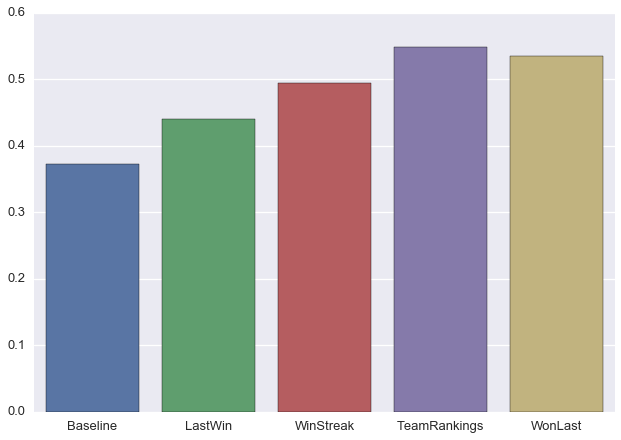

In [31]:
# Let's visually summarize our performance
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_area_auto_adjustable

labels = ["Baseline", "LastWin", "WinStreak", "TeamRankings", "WonLast"]
scores = [0.3728, 0.4407, 0.4940, 0.5488, 0.5351]

sns.set(style="darkgrid", context="talk")
sns.barplot(labels, scores)

By adding new features, we see improvements in our model however by continuously adding features that were derived from the  same dataset, our performance improvements were marginally less from each successive addition

- By adding a feature outside of our original dataset, that is "Rankings", we saw a noticable performance boost
- Adding our final feature "WonLast" provided negligible improvements

## Encoding

- One of the most important pieces of information in our dataset we have been ignoring up till now is the actual team themselves
- Currently, the team names are stored as strings (e.g. "Calgary Flames" or "Boston Bruins") and classification methods don't work too well with these
- By utilizing the 'one hot encoder' feature provided by Scikit-Learn, we can label the team names in a numeric fashion so that our classifier can understand them and potentially provide much more information to our model in determining winners

What will happen is we will be creating a feature that will ask a question:
- Was this team the Calgary Flames?

And the answer will result in values like:
- 1 (for yes) and 0 (for no)

In [32]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
encoding = LabelEncoder() # encoding object has LabelEncoder ready to use
encoding.fit(results["Home Team"].values) # give each team a number to identify them by

LabelEncoder()

In [33]:
home_teams = encoding.transform(results["Home Team"].values)
visitor_teams = encoding.transform(results["Visitor Team"].values)

# vstack allows you to stack a sequence of arrays vertically - in this case we do it to make easy comparisons
X_teams = np.vstack([home_teams, visitor_teams]).T # transpose

X_teams[:5], X_teams.shape

(array([[ 6, 28],
        [11, 29],
        [15, 26],
        [ 7,  0],
        [10,  3]], dtype=int64), (1327, 2))

In this case, we can see the Chicago Blackhawks (6) is paired with the Washington Capitals (28) in the first pair [6, 28].
We know it is these two teams by running the two commands below:

In [34]:
results["Home Team"].values

array(['Chicago Blackhawks', 'Edmonton Oilers', 'Montreal Canadiens', ...,
       'New York Rangers', 'New York Rangers', 'Los Angeles Kings'], dtype=object)

In [35]:
results["Visitor Team"].values

array(['Washington Capitals', 'Winnipeg Jets', 'Toronto Maple Leafs', ...,
       'Los Angeles Kings', 'Los Angeles Kings', 'New York Rangers'], dtype=object)

In [36]:
# Prepare the One Hot Encoder
onehot = OneHotEncoder()
X_teams = onehot.fit_transform(X_teams).todense() # todense returns a matrix

In [37]:
X_teams.shape # see matrix dimensions

(1327, 60)

In [38]:
print("Home:", X_teams[0, :30])
print("Visitor:", X_teams[0, :30])

Home: [[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Visitor: [[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


Above is large matrix (with dimensions 1327 x 60) that has the list of team names and will mark as "1" if the team name is found within it.

By doing this, our model can now understand team names when doing its calculations.

In [39]:
# Lets build our model using the Decision Tree Classifier
tree_clf = DecisionTreeClassifier(random_state=10)
scores = cross_val_score(tree_clf, X_teams, y_true, scoring=scorer)

# Note: The only feature is the encoder we just made
print("The F1 score using encoded teams is the following: {0:.4f}".format(np.mean(scores)))

The F1 score using encoded teams is the following: 0.5371


This is not a bad score, recall our F1 scores from this dataframe:

In [40]:
df

,F1 Score,Overall Performance Boost
Baseline,0.3728,0.0000
Last Win,0.4407,0.0679
Win Streaks & Last Win,0.4940,0.0533
Team Rankings & Last Win,0.5488,0.1081
"Won Last, Team Rankings, & Last Win",0.5351,0.0944


# Random Forest Classifier

Up to now we've been using only the Decision Tree Classifier as our tool to building our model. Could we potentially produce a better model if we were to use a Random Forest Classifier?

In [41]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=10)
scores = cross_val_score(forest_clf, X_teams, y_true, scoring=scorer)
print("The F1 score using Random Forest Classifier is the following: {0:.4f}".format(np.mean(scores)))

The F1 score using Random Forest Classifier is the following: 0.5460


There was a marginal drop in performance (as compared to our "Team Rankings & Last Win" model) which could potentially be explained by overfitting or other randomness factors

Could we do better moving away from the default values using GridSearchCV **with** Random Forest Classifier?

## GridSearchCV with Random Forest Classifier

In [42]:
# Will take some time to run
parameter_space = {
    "max_features": [2, 10, 50, 'auto'],
    "n_estimators": [50, 100, 200],
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": [1,2,4,6],
}

forest_clf = RandomForestClassifier(random_state=10)
grid = GridSearchCV(forest_clf, parameter_space, scoring=scorer)
grid.fit(X_teams, y_true)

# View results
print("F1: {0:.4f}".format(grid.best_score_))
print(grid.best_estimator_)

F1: 0.5840
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=50, max_leaf_nodes=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False)


Our best result was an F1 score of 0.5840 with the following parameters:

- **Max_features** = 50
- **n_estimators** = 100 (the number of tress in the forest)
- **Criterion** = entropy (information gain/ certainty)
- **min_samples_leaf** = 4 (minimum number of samples in a leaf; a split is discarded if after a split, at least one of the leaves contains less than "min_samples_leaf" samples)

## Combine Encoded attribute with Previous Attributes

Let us combine our previous attributes and our new encoded attribute to see the overall performance change:

In [43]:
X_all = np.hstack([X_last_win, X_teams])
print(X_all.shape)

(1327, 64)


In [44]:
# Decision Tree Classifier
tree_clf = DecisionTreeClassifier(random_state=10)
scores = cross_val_score(tree_clf, X_all, y_true, scoring=scorer)
print("F1 score: {0:.4f}".format(np.mean(scores)))

F1 score: 0.5398


In [45]:
# Random Forest Classifier
parameter_space = {
    "max_features": [2, 10, 50, 'auto'],
    "n_estimators": [50, 100, 200],
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": [1,2,4,6],
}

forest_clf = RandomForestClassifier(random_state=10)
grid = GridSearchCV(forest_clf, parameter_space, scoring=scorer)
grid.fit(X_all, y_true)
print("F1 score: {0:.4f}".format(grid.best_score_))
print(grid.best_estimator_)

F1 score: 0.5904
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False)


## Final Results

Let us take a look at our previous and final results

Note:
- DT = Decision Tree
- RF = Random Forest

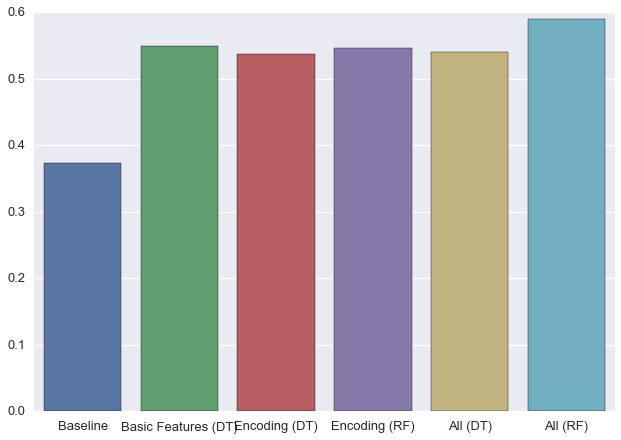

In [46]:
labels = ["Baseline", "Basic Features (DT)", "Encoding (DT)", "Encoding (RF)", "All (DT)", "All (RF)"]
scores = [0.3728, 0.5488, 0.5371, 0.5460, 0.5398, 0.5904]
sns.set(style="darkgrid", context="talk")
sns.barplot(labels, scores);

Our initial F1 score was 0.3782 and by including new features, the overall F1 score improved to 0.5904

Now that we have built a model that successfully improved the performance of predicting winning teams, let us test to see if our model is able to do the same on the 2015 season.

## Testing our Model on the 2015 Season

Let us predict the results of the 2015 season by using our previous model. One thing to note is we will need to create all the features again on the 2015 dataset. In the future if the model is sufficient, a data pipeline could be built so that we could feed the data directly to the model.

In [47]:
# Parse files
games_filename = ('leagues_NHL_2015_games_games.csv')
playoff_filename = ('leagues_NHL_2015_games_games_playoffs.csv')

In [48]:
# Combine files
results1 = pd.read_csv(games_filename, parse_dates=["Date"])
results2 = pd.read_csv(playoff_filename, parse_dates=["Date"])
games_2015 = results1.append(results2, ignore_index= True)

# Fix the names of the columns
games_2015.columns = ["Date", "Visitor Team", "Visitor Goals", "Home Team", "Home Goals", "Overtime", "Blank", "Att", "LOG", "Notes1", "Notes2"]

# Delete the columns we do not need
games_2015 = games_2015.drop(games_2015.columns[[5,6,7,8,9,10]], axis=1)

In [49]:
# Create feature HomeWin
games_2015["HomeWin"] = games_2015["Visitor Goals"] < games_2015["Home Goals"]

In [50]:
# Create HomeLastWin and VisitorLastWin
games_2015["HomeLastWin"] = False
games_2015["VisitorLastWin"] = False

won_last = defaultdict(int)

for index, row in games_2015.iterrows(): # for each row
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]
    row["HomeLastWin"] = won_last[home_team]
    row["VisitorLastWin"] = won_last[visitor_team]
    games_2015.ix[index] = row
    # Set which team won
    won_last[home_team] = row["HomeWin"] # set HomeLastWin as True if "HomeWin" is True
    won_last[visitor_team] = not row["HomeWin"] # otherwise set "VisitorLastWin" as True

In [51]:
# Create HomeWinStreak and VisitorWinStreak
games_2015["HomeWinStreak"] = 0
games_2015["VisitorWinStreak"] = 0

from collections import defaultdict
win_streak = defaultdict(int)

for index, row in games_2015.iterrows():
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]
    row["HomeWinStreak"] = win_streak[home_team]
    row["VisitorWinStreak"] = win_streak[visitor_team]
    games_2015.ix[index] = row
    
    if row["HomeWin"]:
        win_streak[home_team] += 1 # if "HomeWin" is True, increase home_team by 1
        win_streak[visitor_team] = 0
    else:
        win_streak[home_team] = 0
        win_streak[visitor_team] += 1 # if "HomeWin" is False, increase visitor_team by 1

In [52]:
# Parse ranking file
ladders_filename = ('leagues_NHL_2014_standings_standings.csv')
ladder_2014 = pd.read_csv(ladders_filename, skiprows = [0,1], index_col="Team")

In [53]:
# Create HomeTeamRanksHigher
def home_team_ranks_higher(row):
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]
    
    if home_team == "Arizona Coyotes":
        home_team = "Phoenix Coyotes"
    if visitor_team == "Arizona Coyotes":
        visitor_team = "Phoenix Coyotes"
    
    home_rank = ladder_2014.loc[home_team]["Rk"]
    visitor_rank = ladder_2014.loc[visitor_team]["Rk"]
    return home_rank < visitor_rank # Remember, a higher ranking is a lower number (in other words, 1st place > 2nd place)

# This will return a boolean result, either True or False and the command below will take whatever this boolean result is
# and place it into "HomeTeamRanksHigher"
games_2015["HomeTeamRanksHigher"] = games_2015.apply(home_team_ranks_higher, axis=1)

In [54]:
# Create HomeTeamWonLast
last_match_winner = defaultdict(int)

def home_team_won_last(row):
    home_team = row["Home Team"] # get the strings of team names into the respective variables
    visitor_team = row["Visitor Team"]
    
    # Sort team names for a consistent ordering (sorts by alphabetical order)
    teams = tuple(sorted([home_team, visitor_team]))
    
    # So if the home team won the previous game, the "result" of this function will be 1, otherwise 0 if they didn't win
    result = 1 if last_match_winner[teams] == row["Home Team"] else 0
    
    # Update record for next encounter and place the string of the winning team into the dictionary "last_match_winner"
    winner = row["Home Team"] if row["HomeWin"] else row["Visitor Team"]
    
    last_match_winner[teams] = winner
    return result

games_2015["HomeTeamWonLast"] = games_2015.apply(home_team_won_last, axis=1)

In [55]:
# Extract all the features we need
X_basic_features_2015 = games_2015[["HomeLastWin", "VisitorLastWin", "HomeTeamRanksHigher", "HomeTeamWonLast"]]

Important note:

We **need to use the same encoder as before** because the team names have already been encoded and attempting to encode them again will result in different numbers for different teams.

In [56]:
home_teams_2015 = encoding.transform(games_2015["Home Team"].values)
visitor_teams_2015 = encoding.transform(games_2015["Visitor Team"].values)
X_teams_2015 = np.vstack([home_teams_2015, visitor_teams_2015]).T
X_teams_2015 = onehot.transform(X_teams_2015).todense()

In [57]:
# Combine everything
X_all_2015 = np.hstack([X_basic_features_2015, X_teams_2015])
X_all_2015.shape

(1319, 64)

# 2015 Baseline

In [58]:
# This will be the class we are trying to predict for our model, whether the home team won or not
y_test = games_2015["HomeWin"].values

In [59]:
print("Home team wins {:.2f}% of matches".format(100*np.mean(y_test)))
y_pred = [1] * len(y_test)
print("F1 Score: {:.4f}".format(f1_score(y_test, y_pred, pos_label=None, average='weighted')))
print(classification_report(y_test, y_pred))

Home team wins 54.36% of matches
F1 Score: 0.3829
             precision    recall  f1-score   support

      False       0.00      0.00      0.00       602
       True       0.54      1.00      0.70       717

avg / total       0.30      0.54      0.38      1319



C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**We are attempting to outperform an F1 score of 0.38.**

In [60]:
# Predict 2015 results using our 2014 model
y_pred = grid.predict(X_all_2015)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.51      0.44      0.47       602
       True       0.58      0.65      0.61       717

avg / total       0.55      0.55      0.55      1319



In [61]:
print("This results in getting {:.1f}% of predictions correct!".format(100*np.mean(y_pred == y_test)))

This results in getting 55.4% of predictions correct!


## Conclusions

Our final model we produced based off of the 2014 NHL data uses the Random Forest Classifier with the following parameters:
- **n_features** = 'auto'
- **n_estimators** = 100
- **criterion** = 'gini'
- **min_samples_leaf** = 4

By using this model, we attempt to predict for the 2015 season. Here are the results for the 2015 season:
- **Baseline F1 score**: 0.38 
- **Model F1 score**: 0.55


- **Baseline accuracy**: 54.36%
- **Model accuracy**: 55.4%

While we significantly improved our F1 score, the overall accuracy has barely improved; guessing at random is almost just as good as using our model to predict.

## Special Thanks

Special thanks to Robert Layton for the inspiration of creating this project. Some of the earlier steps were similarly replicated from his book, Learning Data Mining with Python.

<img src="book_cover.jpg">

Here is a link to an excerpt to his book: https://www.packtpub.com/books/content/predicting-sports-winners-decision-trees-and-pandas